In [11]:
# Packages
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def plot_solutions(x, y, u_approx, u_exact, residual):
    # Compute the error
    l2_error = np.linalg.norm(u_approx - u_exact, 2)
    max_error = np.max(np.abs(u_approx - u_exact))

    print('{:.3e}'.format(l2_error) + ' {:.3e}'.format(max_error))
    
    # Prepare meshgrid for plotting
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # Plotting
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    # Approximate solution
    c1 = axes[0,0].pcolormesh(X, Y, u_approx, shading='auto', cmap='viridis')
    fig.colorbar(c1, ax=axes[0,0])
    axes[0,0].set_title('Approximate Solution')
    axes[0,0].set_xlabel('x')
    axes[0,0].set_ylabel('y')
    
    # Exact solution
    c2 = axes[0,1].pcolormesh(X, Y, u_exact, shading='auto', cmap='viridis')
    fig.colorbar(c2, ax=axes[0,1])
    axes[0,1].set_title('Exact Solution')
    axes[0,1].set_xlabel('x')
    axes[0,1].set_ylabel('y')
    
    # Error
    c3 = axes[1,0].pcolormesh(X, Y, np.abs(u_approx - u_exact), shading='auto', cmap='inferno')
    fig.colorbar(c3, ax=axes[1,0])
    axes[1,0].set_title('Error')
    axes[1,0].set_xlabel('x')
    axes[1,0].set_ylabel('y')

    c4 = axes[1,1].pcolormesh(X, Y, residual, shading='auto', cmap='inferno')
    fig.colorbar(c4, ax=axes[1,1])
    axes[1,1].set_title('Residual')
    axes[1,1].set_xlabel('x')
    axes[1,1].set_ylabel('y')

    plt.tight_layout()
    plt.show()

In [13]:
def restriction(full_grid):
    N = (full_grid.shape[0] - 2) // 2  # New coarse size
    coarse_grid = np.zeros((N + 2, N + 2))
    
    # Select inner points to be calculated
    ii = np.arange(2, 2*N + 2, 2)
    jj = ii[:, np.newaxis]

    # Calculate weighted average contributions
    central = full_grid[ii, jj] * 0.25
    horizontal = (full_grid[ii+1, jj] + full_grid[ii-1, jj]) * 0.125
    vertical = (full_grid[ii, jj+1] + full_grid[ii, jj-1]) * 0.125
    diagonal = (full_grid[ii+1, jj+1] + full_grid[ii-1, jj-1] + full_grid[ii-1, jj+1] + full_grid[ii+1, jj-1]) * 0.0625

    # Sum all contributions
    coarse_grid[1:N+1, 1:N+1] = central + horizontal + vertical + diagonal

    return coarse_grid

def prolongation(coarse_grid):
    N = (coarse_grid.shape[0] - 2)  # Coarse grid inner points
    fine_N = 2 * N  # Fine grid inner points
    fine_grid = np.zeros((fine_N + 2, fine_N + 2))
    
    # Define indices for accessing coarse grid points
    i = np.arange(1, N+1)
    j = i[:, np.newaxis]

    ii = 2 * i
    jj = 2 * j

    # Direct assignments
    fine_grid[ii-1, jj-1] = coarse_grid[i, j]
    
    # Interpolations along axes
    fine_grid[ii, jj-1] = 0.5 * (coarse_grid[i, j] + coarse_grid[np.minimum(i+1, N), j])
    fine_grid[ii-1, jj] = 0.5 * (coarse_grid[i, j] + coarse_grid[i, np.minimum(j+1, N)])

    # Diagonal interpolation
    fine_grid[ii, jj] = 0.25 * (coarse_grid[i, j] + coarse_grid[np.minimum(i+1, N), j] +
                                coarse_grid[i, np.minimum(j+1, N)] + coarse_grid[np.minimum(i+1, N), np.minimum(j+1, N)])

    return fine_grid

In [14]:
def initialize_poisson_problem(N):
    # Grid spacing
    h = 1.0 / (N + 1)
    x = np.linspace(0, 1, N+2)  # include boundary points
    y = np.linspace(0, 1, N+2)  # include boundary points
    
    # Initialize solution and RHS arrays
    u = np.zeros((N+2, N+2))  # include boundary values, initialized to zero
    f = np.zeros((N+2, N+2))
    r = np.zeros((N+2, N+2))
    
    # Use outer product for right-hand side f(x, y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    f[1:N+1, 1:N+1] = -2 * (np.pi**2) * np.sin(np.pi * X[1:N+1, 1:N+1]) * np.sin(np.pi * Y[1:N+1, 1:N+1])
    
    return u, f, r, h

In [15]:
def compute_analytical_solution(x, y):
    # Create a meshgrid for the x and y arrays
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Compute the analytical solution on the grid using vectorized operations
    u_exact = np.sin(np.pi * X) * np.sin(np.pi * Y)

    return u_exact

In [16]:
def compute_residual(u, f, r, h):
    N = u.shape[0] - 2
    
    # Vectorize the Laplacian calculation except at the boundaries
    laplacian_u = (u[2:N+2, 1:N+1] + u[0:N, 1:N+1] + 
                   u[1:N+1, 2:N+2] + u[1:N+1, 0:N] - 
                   4 * u[1:N+1, 1:N+1]) / h**2
                   
    r[1:N+1, 1:N+1] = f[1:N+1, 1:N+1] - laplacian_u
    
    return

def gauss_seidel_smoothing(u, f, h, num_iterations):
    N = u.shape[0] - 2  # Exclude boundary points
    for _ in range(num_iterations):
        for i in range(1, N+1):
            for j in range(1, N+1):
                u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - h**2 * f[i, j])

    return

In [17]:
def V_cycle(phi, f, r, h, iterations, max_level_iterations, max_levels, level):
    print(f"Level {level}: Grid size {phi.shape}")
    if level == max_levels:
        # Direct solve at the coarsest level (simulated by multiple Gauss-Seidel iterations)
        gauss_seidel_smoothing(phi, f, h, max_level_iterations)
        return
    else:
        
        #Pre-smoothing
        gauss_seidel_smoothing(phi, f, h, iterations)
        
        # Compute Residual Errors
        compute_residual(phi, f, r, h)

        # Restriction
        rhs = restriction(r)
        
        eps = np.zeros_like(rhs)
        rc = np.zeros_like(rhs)
        
        # Stop recursion at smallest grid size, otherwise continue recursion
        V_cycle(eps, rhs, rc, 2*h, iterations, max_level_iterations, max_levels, level=level+1)
        
        # Prolongation and Correction
        phi += prolongation(eps)
        
        # Post-smoothing
        gauss_seidel_smoothing(phi, f, h, iterations)
        
        return


In [18]:
def W_cycle(phi, f, r, h, iterations, max_level_iterations, max_levels, level):
    #print(f"Level {level}: Grid size {phi.shape}")
    if level == max_levels:
        # Direct solve at the coarsest level (simulated by multiple Gauss-Seidel iterations)
        gauss_seidel_smoothing(phi, f, h, max_level_iterations)
        return
    else:

        # Pre-smoothing
        gauss_seidel_smoothing(phi, f, h, iterations)
        
        # Compute Residual Errors
        compute_residual(phi, f, r, h)

        # Restriction
        rhs = restriction(r)

        eps = np.zeros_like(rhs)
        rc = np.zeros_like(rhs)
        
        # Step 3: First recursive call (W-cycle first visit)
        W_cycle(eps, rhs, rc, 2*h, iterations, max_level_iterations, max_levels, level=level+1)
        
        # Prolongation and correction
        phi += prolongation(eps)

        # Re-smoothing
        gauss_seidel_smoothing(phi, f, h, iterations)

        # Compute Residual Errors
        compute_residual(phi, f, r, h)

        # Restriction
        rhs = restriction(r)
        
        # Stop recursion at smallest grid size, otherwise continue recursion
        W_cycle(eps, rhs, rc, 2*h, iterations, max_level_iterations, max_levels, level=level+1)
        
        # Prolongation and correction
        phi += prolongation(eps)

        # Post-smoothing
        gauss_seidel_smoothing(phi, f, h, iterations)
        
        return


In [19]:
# Parameters
grid_size = 64
iterations = 600
max_level_iterations = iterations

max_levels = 4

# Example: Initialize a grid
u_initial, f_initial, r_initial, h_initial = initialize_poisson_problem(grid_size)

# Run the Gauss-Seidel solver
#V_cycle(u_initial, f_initial, r_initial, h_initial, iterations, max_level_iterations, max_levels, 1)
W_cycle(u_initial, f_initial, r_initial, h_initial, iterations, max_level_iterations, max_levels, 1)

# Compute the analytical solution
x = np.linspace(0, 1, u_initial.shape[0])
y = np.linspace(0, 1, u_initial.shape[0])
u_exact = compute_analytical_solution(x, y)

6.301e-03 1.940e-04


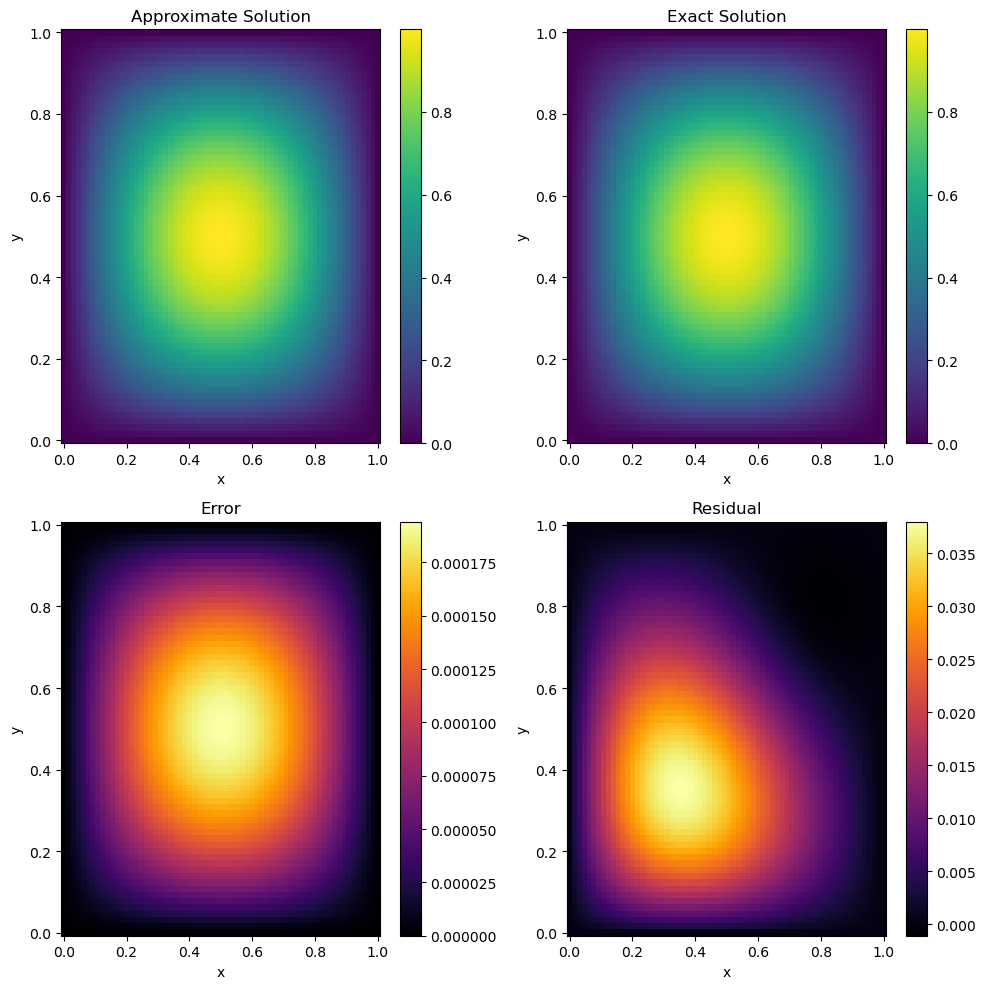

In [20]:
# Run the plotting function with our solutions
plot_solutions(x, y, u_initial, u_exact, r_initial)

# MxN stencil_size, W-cycle, L2-error, Max-error
# 64x64 3x3 1 6.327e-03 1.946e-04
